In [1]:
%matplotlib inline
import math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit
from scipy import signal
from os import path
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding, Dense, Activation, Dropout, LSTM
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


Using TensorFlow backend.


In [145]:
plt.rc('text', usetex=True)

outpath = "../../../plots/temperatures"
inpath = "../../../"

currentfile = "Imitator_2_2400.csv"

# Read from file
strdatatype = np.dtype([('N', np.int_, (2,)), ('Time_Count', np.int_ ), ('Mode', np.int_ ),
                        ('T', np.float_, (10,)), ('S', np.bool_, (10,)), ('System_State', np.bool_ )])
N, Time_Count, Mode, T, S, System_State = np.loadtxt(path.join(inpath, currentfile), 
                                                     unpack=True, delimiter=';', skiprows=1, dtype=strdatatype)

In [146]:
max_possible_model_temperature = 15.0
min_possible_model_temperature = 70.0
def scale_T(_T):
    return (_T - min_possible_model_temperature) / (max_possible_model_temperature - min_possible_model_temperature)

def unscale_T(_T):
    return (_T) * (max_possible_model_temperature - min_possible_model_temperature) + min_possible_model_temperature

In [147]:
outputBlockId=9

In [148]:
sT = scale_T(T)

In [149]:
delta = np.amin(np.abs(sT[:-2, :] - sT[1:-1, :])) 

In [150]:
delta

2.1317509536489254e-06

In [151]:
#data augmintation -- 50000 slightly tuned copies of T
agmntCount=5
agmntdT=np.zeros((agmntCount, np.size(sT[:,0]), np.size(sT[0,:])))
agmntdT[0,:,:] = sT
np.random.seed(0)
mu, sigma = 0, delta*10
for i in range(1, agmntCount):
    agmntdT[i] = agmntdT[0] + np.random.normal(mu, sigma, (np.size(sT[:,0]), np.size(sT[0,:])))

In [152]:
agmntdT.shape

(5, 2401, 10)

In [153]:
predictSteps = 1

In [154]:
#Keep dataset tail for validate prediction quality
cutFromTail = 150
#In order to have shifted and unshifted series with same shape
t = cutFromTail + predictSteps

In [155]:
inData = np.zeros((agmntCount, np.size(sT[:-t,0]), np.size(sT[0,:]) + 1))
for i in range(0, agmntCount):
    inData[i,:,0] = Mode[:-t] / np.amax(Mode[:-t])
    inData[i,:,1:]= agmntdT[i,:-t,:]

In [156]:
inData.shape

(5, 2250, 11)

In [157]:
outData = np.expand_dims(agmntdT[:,predictSteps:-cutFromTail,outputBlockId], axis=2) 

In [158]:
outData.shape

(5, 2250, 1)

In [159]:
num_data = len(inData[0,:,0])
num_data

2250

In [160]:
train_split = 0.7

In [161]:
num_train = int(train_split * num_data)
num_train

1575

In [162]:
num_test = num_data - num_train
num_test

675

In [163]:
inData_train = inData[:, 0:num_train, :]
inData_test = inData[:, num_train:, :]
len(inData_train[0,:,0]) + len(inData_test[0,:,0])

2250

In [164]:
outData_train = outData[:, 0:num_train, :]
outData_test = outData[:, num_train:, :]
len(outData_train[0,:,0]) + len(outData_test[0,:,0])

2250

In [165]:
num_inData_signals = inData.shape[2]
num_inData_signals

11

In [166]:
num_outData_signals = outData.shape[2]
num_outData_signals

1

In [167]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6056530291424643667
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3613720576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13718772714801145420
physical_device_desc: "device: 0, name: GeForce GTX 770, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [168]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        in_shape = (batch_size, sequence_length, num_inData_signals)
        in_batch = np.zeros(shape=in_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        out_shape = (batch_size, sequence_length, num_outData_signals)
        out_batch = np.zeros(shape=out_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # This points somewhere into the augmented series range.
            idaugmnt = np.random.randint(agmntCount)
            
            # Copy the sequences of data starting at this index.
            in_batch[i] = inData_train[idaugmnt, idx:idx+sequence_length,:]
            out_batch[i] = outData_train[idaugmnt, idx:idx+sequence_length,:]
        
        yield (in_batch, out_batch)

In [169]:
batch_size = 512

In [170]:
#sequence_length=576
sequence_length=240

In [190]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [191]:
in_batch, out_batch = next(generator)

In [192]:
print(in_batch.shape)
print(out_batch.shape)

(512, 240, 11)
(512, 240, 1)


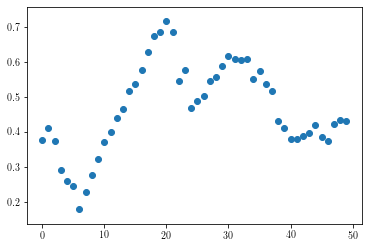

In [193]:
batch = 0   # First sequence in the batch.
seq = in_batch[batch,predictSteps:predictSteps+50, outputBlockId+1]
plt.scatter(np.arange(0, len(seq)), seq)

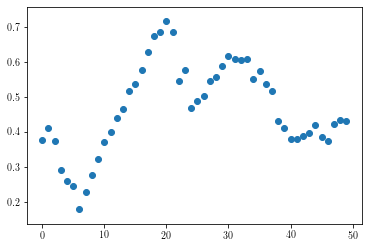

In [194]:
seq = out_batch[batch, 0:50, 0]
plt.scatter(np.arange(0, len(seq)),seq)

In [195]:
validation_data = (np.expand_dims(inData_test[0,:,:], axis=0),
                   np.expand_dims(outData_test[0,:,:], axis=0))

In [196]:
model = Sequential()

In [197]:
model.add(LSTM(75, return_sequences=True, input_shape=(None, num_inData_signals,)))
model.add(LSTM(48, return_sequences=True))
#model.add(LSTM(12, return_sequences=True))
#model.add(LSTM(3, return_sequences=True))
model.add(Dense(1, activation = "linear"))

In [198]:
warmup_steps = 1
import keras.backend as K
def loss_mse_warmup(y_true, y_pred): 
    return K.mean(K.square(y_pred[:, warmup_steps:, :]-y_true[:, warmup_steps:, :]))

In [199]:
#model.compile(Adam(learning_rate=1e-3), loss='mean_absolute_error')
model.compile(Adam(learning_rate=1e-3), loss=loss_mse_warmup)

In [200]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 75)          26100     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 48)          23808     
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           49        
Total params: 49,957
Trainable params: 49,957
Non-trainable params: 0
_________________________________________________________________


In [201]:
path_checkpoint = str(outputBlockId)+'_checkpoint_test.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [202]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [203]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [204]:
callbacks = [callback_early_stopping,
            callback_checkpoint,
            callback_reduce_lr]

In [205]:
%%time
#model.fit_generator(generator=generator,
#                    epochs=1000,
#                    steps_per_epoch=50,
#                    validation_data=validation_data,
#                    callbacks=callbacks)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [206]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [207]:
result = model.evaluate(x=np.expand_dims(inData_test[0], axis=0),
                        y=np.expand_dims(outData_test[0], axis=0))

1/1 [==============================] - 0s 200ms/step


In [208]:
print("loss (test-set):", result)

loss (test-set): 0.002553283702582121


In [217]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = inData_train[0]
        y_true = outData_train[0]
    else:
        # Use test-data.
        x = inData_test[0]
        y_true = outData_test[0]
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print(shape(x))
    print(shape(y_pred))
        
    # Get the output-signal predicted by the model.
    signal_pred = y_pred
        
    # Get the true output-signal from the data-set.
    signal_true = y_true
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.scatter(np.arange(0, len(signal_pred[0])-1), signal_pred[0,1:,:], label='pred', color='r')

        
    # Plot labels etc.
    plt.legend()
    plt.show()

(1, 200, 11)
(1, 200, 1)


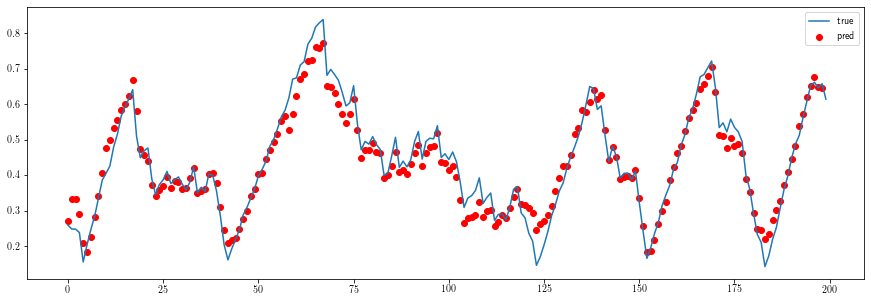

In [218]:
plot_comparison(start_idx=60, length=200, train=False)


In [264]:
sequence_length_for_predict = sequence_length

def predStepForAllBlc(_in):
    _out = np.zeros((1, sequence_length_for_predict, 10))
    for blk_id in range(0, 10):
            path_to_current_model = str(blk_id)+'_checkpoint_test.keras'
            try:
                model.load_weights(path_to_current_model)
            except Exception as error:
                print("Error trying to load model for block "+str(blk_id+1))
                print(error)
            _out[0, :, blk_id] = model.predict(_in)[0,:,0]
    return _out[0, -predictSteps, :]
            
def performOfSamplePrediction(outOfSampleCount):    
    prediction = np.zeros((outOfSampleCount, 10))
    
    predictBase = np.zeros((1, sequence_length_for_predict, num_inData_signals))
    onStepPredict = np.zeros((1, sequence_length_for_predict, 10))
    
    Modes = Mode[-(sequence_length_for_predict + cutFromTail): -cutFromTail] / 4.0
    predictBase[0,:,0] = Modes    
    predictBase[0,:,1:] = sT[-(sequence_length_for_predict + cutFromTail): -cutFromTail,:]
        
    #predict 1st point -- Modes values from train dataset    
    prediction[0,:] = predStepForAllBlc(predictBase)
    for step in range(1,outOfSampleCount):
        #predict over 1st point -- need to guess which Mode value to choose
        #baseline solution -- use mean value over 5 mode values
        predictBase[0,:-1,1:] = predictBase[0,1:,1:]
        predictBase[0,-1,1:] = prediction[step - 1,:]
        Modes[:-1] = Modes[1:]
        sumBuffer = np.zeros(10)
        for currentmodeguess in range(0, 1):
            Modes[-1] = currentmodeguess / 4.0
            predictBase[0,:,0] = Modes
            sumBuffer += predStepForAllBlc(predictBase)
        sumBuffer = sumBuffer
        prediction[step,:] = sumBuffer
    
    return prediction
           
        

In [280]:
pred = performOfSamplePrediction(predictSteps + cutFromTail)

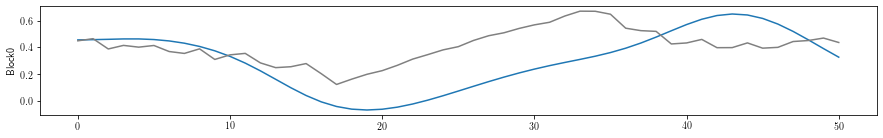

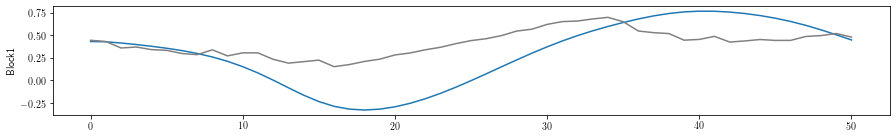

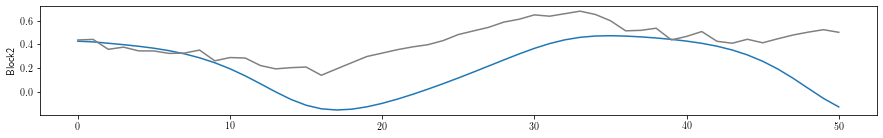

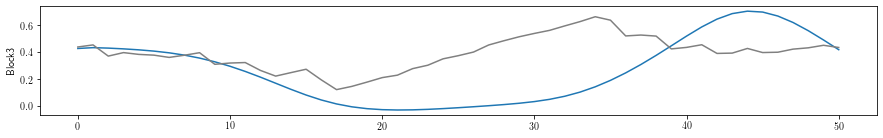

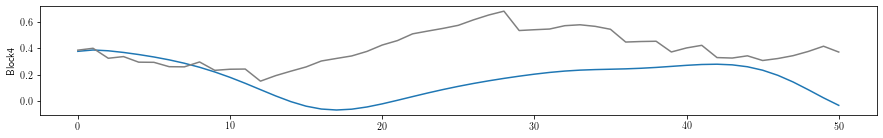

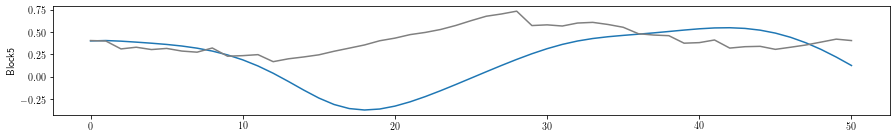

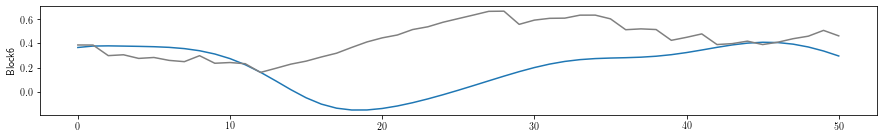

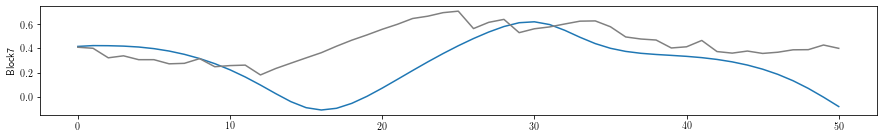

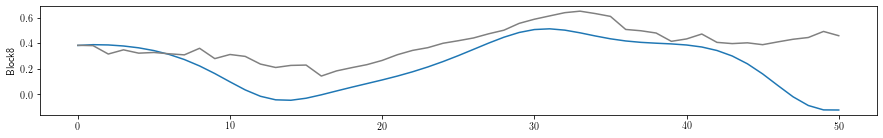

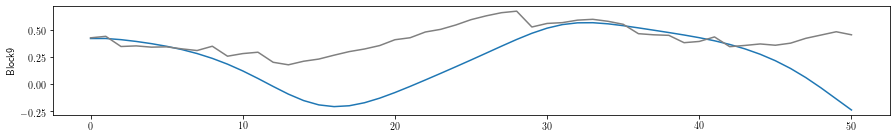

In [286]:
for _id in range (0, 10):
    plt.figure(figsize=(15,2))
    plt.plot(pred[:-100,_id])
    plt.plot(sT[-(predictSteps + cutFromTail):-100, _id], color='gray')
    plt.ylabel("Block"+str(_id))